In [1]:
import os
os.getcwd()

'C:\\Users\\Sezin\\Documents\\FoodAI\\feature_selection\\30_12_12_leave_group_o\\Figures\\MLP'

# chewiness

   protein  target moisture  moisture     ash   carbs    fat  fiber
0  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
1  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
2  62.6988            57.16    5.3937  4.2445  20.491  6.662   0.51
3  63.1788            57.51    5.9137  3.9545  19.861  6.582   0.51
4  63.1788            57.24    5.9137  3.9545  19.861  6.582   0.51
   Chewiness
0  38.049816
1  31.294988
2  39.494747
3  26.862429
4  38.977081
[5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]
12
Fitting 11 folds for each of 140 candidates, totalling 1540 fits
Best parameters   {'activation': 'logistic', 'alpha': 0.1, 'hidden_layer_sizes': (3,)}
[  9.40153457 166.69535436  91.0525329   23.39901303 192.78079315
 362.97603572  43.97039968]
Fitting 11 folds for each of 140 candidates, totalling 1540 fits
Best parameters   {'activati

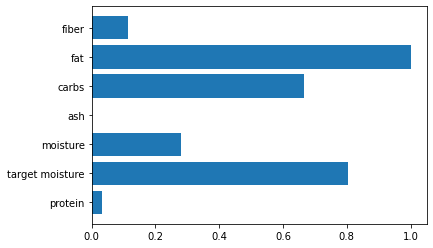

[0, 1, 2, 3, 4, 5, 6]
Number of features: 7
Features: Index(['protein', 'target moisture', 'moisture', 'ash', 'carbs', 'fat',
       'fiber'],
      dtype='object')
Root Mean Squared Error (RMSE): 18.452
Adjusted r2_score: -0.374
r2_score: -0.192
Mean absolute percentage error (MAPE): 42.7%


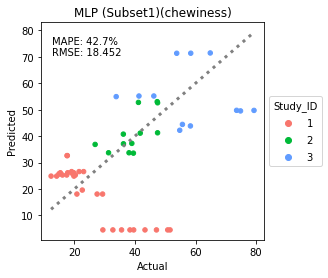

....................................................................................................
Feature: protein, Score: 0.03212
Feature: target moisture, Score: 0.80234
Feature: moisture, Score: 0.28007
Feature: ash, Score: 0.00000
Feature: carbs, Score: 0.66467
Feature: fat, Score: 1.00000
Feature: fiber, Score: 0.11297


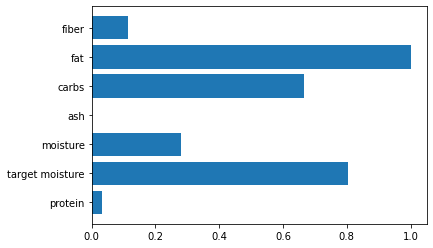

In [20]:
from sklearn.neural_network import MLPRegressor
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePGroupsOut
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression#mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
    
from matplotlib.colors import ListedColormap
    
#data =pd.read_csv('./../Feature_Subsets/30_12_12.csv',header=0)
#features_all=data.iloc[:,1:8]
data =pd.read_csv('./../Feature_Subsets/additional_30_12_12.csv',header=0)
features_all=data.iloc[:,2:9]
columns = list(features_all.columns)

Subsets_Chew =[columns]

for sub_i in range(len(Subsets_Chew)):

    response = 'chewiness'
    if response=='crosswise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,6:7])
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,6:7].head())

    elif response=='lengthwise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,7:8])    
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,7:8].head())    

    elif response=='chewiness':
        #y = np.array(data.iloc[:,9:10])
        y = np.array(data.loc[:,'Chewiness'])

        print(features_all.head())
        print(data.iloc[:,10:11].head())
    elif response=='hardness':
        #y = np.array(data.iloc[:,8:9])
        y = np.array(data.loc[:,'Hardness'])
        print(features_all.head())
        print(data.iloc[:,9:10].head())        

    alphas = [0.0001,0.001,0.01,0.1,0,1,10]
    num_nodes=[1,2,3,4,5]
    act_function = [ 'relu','identity', 'logistic', 'tanh'] #relu
    solver=['sgd'] #adam
    param_grid = {
    'alpha': [0.0001,0.001,0.01,0.1,0,1,10],
    'hidden_layer_sizes':[(1,),(2,),(3,),(4,),(5,)],
     'activation': ['relu','identity', 'logistic', 'tanh']   #relu
    }
    final_importance, final_importance_noabs=list(), list()

    feat=[columns.index(i) for i in Subsets_Chew[sub_i]]
    X = np.array(features_all.iloc[:,feat])


    y_true, predictions, residuals = list(), list(), list()
    loo = LeavePGroupsOut(n_groups=1)
    #groups = data.iloc[:,10:11].values.ravel()
    groups = list(data.Group_ID)
    study_id = data.loc[:,'Study_ID']

    print(groups)
    k_fold=loo.get_n_splits(X,groups=groups)
    print(k_fold)
    grid = dict()
    est = MLPRegressor(max_iter=50000, random_state=0, solver = solver[0])

    g_mse, g_mae, g_rmse, g_r2, g_r2adj,g_mape = list(),list(),list(),list(),list(),list()
    count=0
    predictions_, y_trues_ = list(), list()
    labels, best_params= list(), list()
    importances, no_abs_importance=[],[]
    for train_index, test_index in loo.split(X,groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        count += 1
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        labels.extend(study_id[test_index])

       # scaler = StandardScaler()
       # y_train = scaler.fit_transform(y_train)
       # y_test = scaler.transform(y_test)
        reg = GridSearchCV(estimator=est, param_grid=param_grid, scoring='neg_mean_squared_error' ,cv=loo.split(X_train,y_train,groups=np.array(groups)[train_index]),verbose=1)
        reg.fit(X_train, y_train.ravel())

        print("Best parameters  ", reg.best_params_)
        best_params.append(reg.best_params_)
        
       # reg = RandomForestRegressor(random_state=0).fit(X_train, y_train.ravel())
        prediction = reg.predict(X_test)
        predictions_.extend(prediction)
        y_trues_.extend(y_test.ravel())
        #plt.barh(features_all.iloc[:,feat].columns, reg.feature_importances_)
        #plt.show()
       # residual =  y_test.ravel()-prediction
       # residuals_.append(residual)          

        results = permutation_importance(reg, X_train, y_train.ravel(), scoring='neg_mean_squared_error')
        # get importance
        print(results['importances_mean'])
        importances.append(np.abs(results['importances_mean']))
        no_abs_importance.append(results['importances_mean'])
        pred = predictions_
        true = y_trues_

    importance = np.array(importances).mean(0)
    #x=np.abs(importance)

    no_abs_importance = np.array(no_abs_importance).mean(0)

    importance = (importance-min(importance))/(max(importance)-min(importance))

    if not np.isnan(importance[0]):
        final_importance.append(importance)
        
    if not np.isnan(no_abs_importance[0]):
        final_importance_noabs.append(no_abs_importance)

    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()
    g_mse.append(mean_squared_error(true, pred))
    g_mae.append(mean_absolute_error(true, pred))
    g_rmse.append(mean_squared_error(true, pred, squared=False))
    g_mape.append(mean_absolute_percentage_error(true, pred))
    g_r2.append(r2_score(true, pred))
    g_r2adj.append(1 - (1-r2_score(true, pred))*(len(true)-1)/(len(true)-len(feat)-1))
    error =np.array(g_mse).mean()
    error2 =np.array(g_mae).mean()
    error3 =np.array(g_rmse).mean()
    error4 =  np.mean(np.abs((np.array(true) - np.array(pred))/true))*100
    r2_score_val =np.array(g_r2).mean()
    r2_adj =np.array(g_r2adj).mean()

    print(feat)
    #Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    #A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
    print('Number of features:',  len(feat))
    print('Features:',  features_all.columns[feat])
    #  print('Mean Squared Error (MSE): %.3f' % error) 
    #  print('Mean Absolute Error (MAE): %.3f' % error2) 
    print('Root Mean Squared Error (RMSE): %.3f' % error3) 
    print('Adjusted r2_score: %.3f' %r2_adj)
    print('r2_score: %.3f' % r2_score_val)
    print(f'Mean absolute percentage error (MAPE): {error4:.1f}%')


    error3 = mean_squared_error(true, pred, squared=False)
    r2_score_val = r2_score(true, pred)
    adj_R2=(1 - (1-r2_score_val)*(len(true)-1)/(len(true)-((7))-1))    


    fig, ax = plt.subplots(figsize=(4,4))
    plt.text(x=0.05,y=0.85,s='RMSE: %.3f' % error3, transform=ax.transAxes)
    plt.text(x=0.05,y=0.90,s=f'MAPE: {error4:.1f}%', transform=ax.transAxes)
    #plt.text(x=0.05,y=0.95,s='Adjusted R2: %.3f' % adj_R2, transform=ax.transAxes)
    #plt.text(x=0.05,y=0.90,s='R2: %.3f' % r2_score_val, transform=ax.transAxes)


    plt.title('MLP (Subset'+str(sub_i+1)+')('+response+')')
    #ax.scatter(true, pred,labels)
    colors = ListedColormap(['#F8766D','#00BA38','#619CFF'])

    scatter=plt.scatter(true, pred,c=labels, cmap=colors,s=20)

    true=np.array(true)

    ax.plot([true.min(), true.max()], [true.min(), true.max()], linestyle = 'dotted', lw=3, color='gray')
    ax.legend(*scatter.legend_elements(),title="Study_ID", loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    plt.show()
    print(100*'.')
    final_importance = np.array(final_importance).mean(0)

    fs_scores=[]
    for i,v in enumerate(final_importance):
        print('Feature: %0s, Score: %.5f' % (features_all.iloc[:,feat].columns[i],v))
        fs_scores.append('%0s %.5f' % (features_all.iloc[:,feat].columns[i],v))
    pyplot.barh(features_all.iloc[:,feat].columns, final_importance)
    pyplot.show()

In [21]:
np.savetxt(fname='fs_best_params_'+response+'.txt' , X=best_params, fmt='%s')


In [22]:
np.savetxt(fname='./fs_scores_mlp_'+response+'.txt',X=fs_scores,fmt='%s')

In [ ]:
Subsets_Chew =[['protein','target moisture','carbs','fat']]


# On selected features

   protein  target moisture  moisture     ash   carbs    fat  fiber
0  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
1  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
2  62.6988            57.16    5.3937  4.2445  20.491  6.662   0.51
3  63.1788            57.51    5.9137  3.9545  19.861  6.582   0.51
4  63.1788            57.24    5.9137  3.9545  19.861  6.582   0.51
   Chewiness
0  38.049816
1  31.294988
2  39.494747
3  26.862429
4  38.977081
[5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]
12
Fitting 11 folds for each of 140 candidates, totalling 1540 fits
Mean_val_score   [ -60.01703374 -158.47466948 -167.9550848  -244.33040883 -313.27046073
  -60.0171036  -159.45691234 -167.94285565 -244.2800199  -308.0668629
  -60.01780401 -159.24507432 -167.80246834 -242.77338563 -304.25249938
  -60.02628196 -140.40946552 -165.09240913 -1

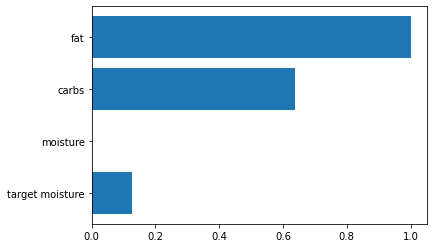

[1, 2, 4, 5]
Number of features: 4
Features: Index(['target moisture', 'moisture', 'carbs', 'fat'], dtype='object')
Root Mean Squared Error (RMSE): 8.018
Root Mean Squared Train Error (RMSE): 4.896
Adjusted r2_score: 0.757
r2_score: 0.775
Mean Absolute Percentage Error (MAPE): 16.3%
Mean Absolute Percentage Train Error (MAPE): 0.1%


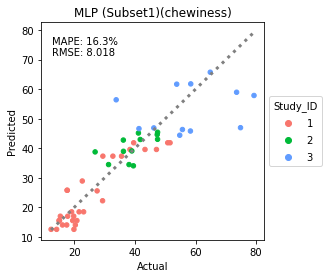

....................................................................................................
Feature: 0, Score: 0.12786
Feature: 1, Score: 0.00000
Feature: 2, Score: 0.63699
Feature: 3, Score: 1.00000


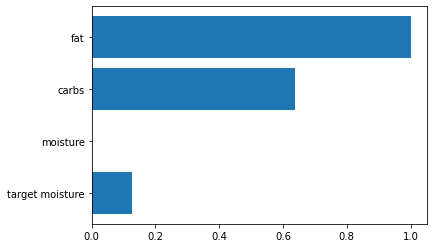

In [3]:
from sklearn.neural_network import MLPRegressor
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePGroupsOut
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression#mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
    
from matplotlib.colors import ListedColormap
    
#data =pd.read_csv('./../Feature_Subsets/30_12_12.csv',header=0)
#features_all=data.iloc[:,1:8]
data =pd.read_csv('./../Feature_Subsets/additional_30_12_12.csv',header=0)
features_all=data.iloc[:,2:9]
columns = list(features_all.columns)

Subsets_Chew =[['target moisture','moisture','carbs','fat']]

for sub_i in range(len(Subsets_Chew)):

    response = 'chewiness'
    if response=='crosswise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,6:7])
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,6:7].head())

    elif response=='lengthwise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,7:8])    
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,7:8].head())    

    elif response=='chewiness':
        #y = np.array(data.iloc[:,9:10])
        y = np.array(data.loc[:,'Chewiness'])

        print(features_all.head())
        print(data.iloc[:,10:11].head())
    elif response=='hardness':
        #y = np.array(data.iloc[:,8:9])
        y = np.array(data.loc[:,'Hardness'])
        print(features_all.head())
        print(data.iloc[:,9:10].head())        

    alphas = [0.0001,0.001,0.01,0.1,0,1,10]
    num_nodes=[1,2,3,4,5]
    act_function = [ 'relu','identity', 'logistic', 'tanh'] #relu
    solver=['sgd'] #adam
    param_grid = {
    'alpha': [0.0001,0.001,0.01,0.1,0,1,10],
    'hidden_layer_sizes':[(1,),(2,),(3,),(4,),(5,)],
     'activation': ['relu','identity', 'logistic', 'tanh']   #relu
    }
    final_importance=list()

    feat=[columns.index(i) for i in Subsets_Chew[sub_i]]
    X = np.array(features_all.iloc[:,feat])


    y_true, predictions, residuals = list(), list(), list()
    loo = LeavePGroupsOut(n_groups=1)
    #groups = data.iloc[:,10:11].values.ravel()
    groups = list(data.Group_ID)
    study_id = data.loc[:,'Study_ID']

    print(groups)
    k_fold=loo.get_n_splits(X,groups=groups)
    print(k_fold)
    grid = dict()
    est = MLPRegressor(max_iter=50000, random_state=0, solver = solver[0])

    g_mse, g_mae, g_rmse, g_r2, g_r2adj,g_mape = list(),list(),list(),list(),list(),list()
    count=0
    predictions_, y_trues_,predictions_train, y_trues_train = list(), list(), list(), list()
    labels, best_params= list(), list()
    importances=[]
    for train_index, test_index in loo.split(X,groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        count += 1
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        labels.extend(study_id[test_index])

       # scaler = StandardScaler()
       # y_train = scaler.fit_transform(y_train)
       # y_test = scaler.transform(y_test)
        reg = GridSearchCV(estimator=est, return_train_score=True, param_grid=param_grid, scoring='neg_mean_squared_error' ,cv=loo.split(X_train,y_train,groups=np.array(groups)[train_index]),verbose=1)
        reg.fit(X_train, y_train.ravel())

        print("Mean_val_score  ", reg.cv_results_['mean_test_score'])
        print("Mean_train_score  ", reg.cv_results_['mean_train_score'])
        print("Ratio test/train  ", reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])

        print("Best parameters  ", reg.best_params_)
        best_params.append(reg.best_params_)

        print("Best parameters test score ",np.sqrt(np.abs(reg.cv_results_['mean_test_score'][reg.best_index_])))
        print("Best parameters train score ",np.sqrt(np.abs(reg.cv_results_['mean_train_score'][reg.best_index_])))
        print("Best parameters ratio test/train ",(reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])[reg.best_index_])
       # reg = RandomForestRegressor(random_state=0).fit(X_train, y_train.ravel())
        prediction = reg.predict(X_test)
        predictions_.extend(prediction)
        y_trues_.extend(y_test.ravel())
        #plt.barh(features_all.iloc[:,feat].columns, reg.feature_importances_)
        #plt.show()
       # residual =  y_test.ravel()-prediction
       # residuals_.append(residual)          
        prediction_tr = reg.predict(X_train)

        predictions_train.extend(prediction_tr)
        y_trues_train.extend(y_train.ravel())
        results = permutation_importance(reg, X_train, y_train.ravel(), scoring='neg_mean_squared_error')
        # get importance
        importance = results.importances_mean
        x=np.abs(importance)

        importance = (x-min(x))/(max(x)-min(x))
        # summarize feature importance
        importances.append(importance)


        pred = predictions_
        true = y_trues_

    importance = np.array(importances).mean(0)
    x=np.abs(importance)

    importance = (x-min(x))/(max(x)-min(x))
    if not np.isnan(importance[0]):
        final_importance.append(importance)
  #  for i,v in enumerate(importance):
  #      print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()
    g_mse.append(mean_squared_error(true, pred))
    g_mae.append(mean_absolute_error(true, pred))
    g_rmse.append(mean_squared_error(true, pred, squared=False))
    g_mape.append(mean_absolute_percentage_error(true, pred))
    g_r2.append(r2_score(true, pred))
    g_r2adj.append(1 - (1-r2_score(true, pred))*(len(true)-1)/(len(true)-len(feat)-1))
    error =np.array(g_mse).mean()
    error2 =np.array(g_mae).mean()
    error3 =np.array(g_rmse).mean()
    error4 =  np.mean(np.abs((np.array(true) - np.array(pred))/true))*100
    r2_score_val =np.array(g_r2).mean()
    r2_adj =np.array(g_r2adj).mean()

    print(feat)
    #Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    #A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
    print('Number of features:',  len(feat))
    print('Features:',  features_all.columns[feat])
    #  print('Mean Squared Error (MSE): %.3f' % error) 
    #  print('Mean Absolute Error (MAE): %.3f' % error2) 
    print('Root Mean Squared Error (RMSE): %.3f' % error3) 
    print('Root Mean Squared Train Error (RMSE): %.3f' % mean_squared_error(y_trues_train, predictions_train, squared=False)) 

    print('Adjusted r2_score: %.3f' %r2_adj)
    print('r2_score: %.3f' % r2_score_val)
    print(f'Mean Absolute Percentage Error (MAPE): {error4:.1f}%')
    print(f'Mean Absolute Percentage Train Error (MAPE): {mean_absolute_percentage_error(y_trues_train, predictions_train):.1f}%')



    error3 = mean_squared_error(true, pred, squared=False)
    r2_score_val = r2_score(true, pred)
    adj_R2=(1 - (1-r2_score_val)*(len(true)-1)/(len(true)-((7))-1))    


    fig, ax = plt.subplots(figsize=(4,4))
    plt.text(x=0.05,y=0.85,s='RMSE: %.3f' % error3, transform=ax.transAxes)
    plt.text(x=0.05,y=0.90,s=f'MAPE: {error4:.1f}%', transform=ax.transAxes)
    #plt.text(x=0.05,y=0.95,s='Adjusted R2: %.3f' % adj_R2, transform=ax.transAxes)
    #plt.text(x=0.05,y=0.90,s='R2: %.3f' % r2_score_val, transform=ax.transAxes)


    plt.title('MLP (Subset'+str(sub_i+1)+')('+response+')')
    #ax.scatter(true, pred,labels)
    colors = ListedColormap(['#F8766D','#00BA38','#619CFF'])

    scatter=plt.scatter(true, pred,c=labels, cmap=colors,s=20)

    true=np.array(true)

    ax.plot([true.min(), true.max()], [true.min(), true.max()], linestyle = 'dotted', lw=3, color='gray')
    ax.legend(*scatter.legend_elements(),title="Study_ID", loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    plt.show()
    print(100*'.')
    final_importance = np.array(final_importance).mean(0)
    x=np.abs(final_importance)

    importance = (x-min(x))/(max(x)-min(x))
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()

In [4]:
np.savetxt(fname='best_params_'+response+'.txt' , X=best_params, fmt='%s')


# hardness

   protein  target moisture  moisture     ash   carbs    fat  fiber
0  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
1  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
2  62.6988            57.16    5.3937  4.2445  20.491  6.662   0.51
3  63.1788            57.51    5.9137  3.9545  19.861  6.582   0.51
4  63.1788            57.24    5.9137  3.9545  19.861  6.582   0.51
   Hardness
0   46.7090
1   40.4365
2   49.0595
3   38.6525
4   50.8115
[5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]
12
Fitting 11 folds for each of 140 candidates, totalling 1540 fits
Best parameters   {'activation': 'relu', 'alpha': 10, 'hidden_layer_sizes': (3,)}
[ 47.43060453  41.15287509 518.64990972 263.84895614 441.32880323
 457.70767322  41.95991904]
Fitting 11 folds for each of 140 candidates, totalling 1540 fits
Best parameters   {'activation': 'tanh'

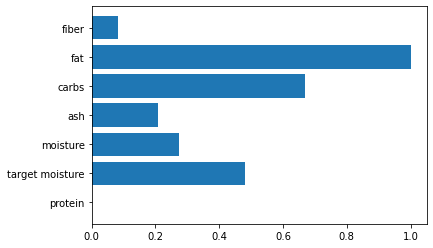

[0, 1, 2, 3, 4, 5, 6]
Number of features: 7
Features: Index(['protein', 'target moisture', 'moisture', 'ash', 'carbs', 'fat',
       'fiber'],
      dtype='object')
Root Mean Squared Error (RMSE): 33.930
Adjusted r2_score: -1.660
r2_score: -1.309
Mean absolute percentage error (MAPE): 75.8%


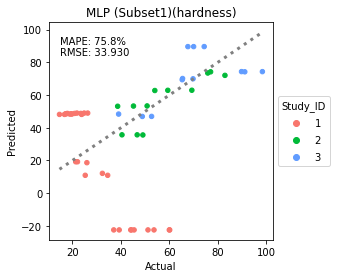

....................................................................................................
Feature: protein, Score: 0.00000
Feature: target moisture, Score: 0.48187
Feature: moisture, Score: 0.27266
Feature: ash, Score: 0.20870
Feature: carbs, Score: 0.66813
Feature: fat, Score: 1.00000
Feature: fiber, Score: 0.08126


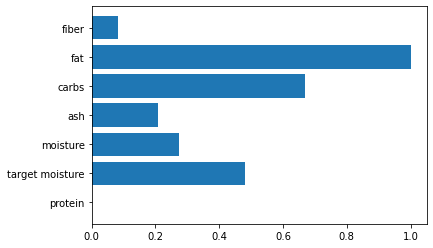

In [17]:
from sklearn.neural_network import MLPRegressor
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePGroupsOut
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression#mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
    
from matplotlib.colors import ListedColormap
    
#data =pd.read_csv('./../Feature_Subsets/30_12_12.csv',header=0)
#features_all=data.iloc[:,1:8]
data =pd.read_csv('./../Feature_Subsets/additional_30_12_12.csv',header=0)
features_all=data.iloc[:,2:9]
columns = list(features_all.columns)

Subsets_Chew =[columns]

for sub_i in range(len(Subsets_Chew)):

    response = 'hardness'
    if response=='crosswise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,6:7])
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,6:7].head())

    elif response=='lengthwise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,7:8])    
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,7:8].head())    

    elif response=='chewiness':
        #y = np.array(data.iloc[:,9:10])
        y = np.array(data.loc[:,'Chewiness'])

        print(features_all.head())
        print(data.iloc[:,10:11].head())
    elif response=='hardness':
        #y = np.array(data.iloc[:,8:9])
        y = np.array(data.loc[:,'Hardness'])
        print(features_all.head())
        print(data.iloc[:,9:10].head())        

    alphas = [0.0001,0.001,0.01,0.1,0,1,10]
    num_nodes=[1,2,3,4,5]
    act_function = [ 'relu','identity', 'logistic', 'tanh'] #relu
    solver=['sgd'] #adam
    param_grid = {
    'alpha': [0.0001,0.001,0.01,0.1,0,1,10],
    'hidden_layer_sizes':[(1,),(2,),(3,),(4,),(5,)],
     'activation': ['relu','identity', 'logistic', 'tanh']   #relu
    }
    final_importance, final_importance_noabs=list(), list()

    feat=[columns.index(i) for i in Subsets_Chew[sub_i]]
    X = np.array(features_all.iloc[:,feat])


    y_true, predictions, residuals = list(), list(), list()
    loo = LeavePGroupsOut(n_groups=1)
    #groups = data.iloc[:,10:11].values.ravel()
    groups = list(data.Group_ID)
    study_id = data.loc[:,'Study_ID']

    print(groups)
    k_fold=loo.get_n_splits(X,groups=groups)
    print(k_fold)
    grid = dict()
    est = MLPRegressor(max_iter=50000, random_state=0, solver = solver[0])

    g_mse, g_mae, g_rmse, g_r2, g_r2adj,g_mape = list(),list(),list(),list(),list(),list()
    count=0
    predictions_, y_trues_ = list(), list()
    labels, best_params= list(), list()
    importances, no_abs_importance=[],[]
    for train_index, test_index in loo.split(X,groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        count += 1
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        labels.extend(study_id[test_index])

       # scaler = StandardScaler()
       # y_train = scaler.fit_transform(y_train)
       # y_test = scaler.transform(y_test)
        reg = GridSearchCV(estimator=est, param_grid=param_grid, scoring='neg_mean_squared_error' ,cv=loo.split(X_train,y_train,groups=np.array(groups)[train_index]),verbose=1)
        reg.fit(X_train, y_train.ravel())

        print("Best parameters  ", reg.best_params_)
        best_params.append(reg.best_params_)
        
       # reg = RandomForestRegressor(random_state=0).fit(X_train, y_train.ravel())
        prediction = reg.predict(X_test)
        predictions_.extend(prediction)
        y_trues_.extend(y_test.ravel())
        #plt.barh(features_all.iloc[:,feat].columns, reg.feature_importances_)
        #plt.show()
       # residual =  y_test.ravel()-prediction
       # residuals_.append(residual)          

        results = permutation_importance(reg, X_train, y_train.ravel(), scoring='neg_mean_squared_error')
        # get importance
        print(results['importances_mean'])
        importances.append(np.abs(results['importances_mean']))
        no_abs_importance.append(results['importances_mean'])
        pred = predictions_
        true = y_trues_

    importance = np.array(importances).mean(0)
    #x=np.abs(importance)
    print('before ',importance)

    no_abs_importance = np.array(no_abs_importance).mean(0)

    importance = (importance-min(importance))/(max(importance)-min(importance))
    print('after ',importance)

    if not np.isnan(importance[0]):
        final_importance.append(importance)
        
    if not np.isnan(no_abs_importance[0]):
        final_importance_noabs.append(no_abs_importance)

    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()
    g_mse.append(mean_squared_error(true, pred))
    g_mae.append(mean_absolute_error(true, pred))
    g_rmse.append(mean_squared_error(true, pred, squared=False))
    g_mape.append(mean_absolute_percentage_error(true, pred))
    g_r2.append(r2_score(true, pred))
    g_r2adj.append(1 - (1-r2_score(true, pred))*(len(true)-1)/(len(true)-len(feat)-1))
    error =np.array(g_mse).mean()
    error2 =np.array(g_mae).mean()
    error3 =np.array(g_rmse).mean()
    error4 =  np.mean(np.abs((np.array(true) - np.array(pred))/true))*100
    r2_score_val =np.array(g_r2).mean()
    r2_adj =np.array(g_r2adj).mean()

    print(feat)
    #Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    #A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
    print('Number of features:',  len(feat))
    print('Features:',  features_all.columns[feat])
    #  print('Mean Squared Error (MSE): %.3f' % error) 
    #  print('Mean Absolute Error (MAE): %.3f' % error2) 
    print('Root Mean Squared Error (RMSE): %.3f' % error3) 
    print('Adjusted r2_score: %.3f' %r2_adj)
    print('r2_score: %.3f' % r2_score_val)
    print(f'Mean absolute percentage error (MAPE): {error4:.1f}%')


    error3 = mean_squared_error(true, pred, squared=False)
    r2_score_val = r2_score(true, pred)
    adj_R2=(1 - (1-r2_score_val)*(len(true)-1)/(len(true)-((7))-1))    


    fig, ax = plt.subplots(figsize=(4,4))
    plt.text(x=0.05,y=0.85,s='RMSE: %.3f' % error3, transform=ax.transAxes)
    plt.text(x=0.05,y=0.90,s=f'MAPE: {error4:.1f}%', transform=ax.transAxes)
    #plt.text(x=0.05,y=0.95,s='Adjusted R2: %.3f' % adj_R2, transform=ax.transAxes)
    #plt.text(x=0.05,y=0.90,s='R2: %.3f' % r2_score_val, transform=ax.transAxes)


    plt.title('MLP (Subset'+str(sub_i+1)+')('+response+')')
    #ax.scatter(true, pred,labels)
    colors = ListedColormap(['#F8766D','#00BA38','#619CFF'])

    scatter=plt.scatter(true, pred,c=labels, cmap=colors,s=20)

    true=np.array(true)

    ax.plot([true.min(), true.max()], [true.min(), true.max()], linestyle = 'dotted', lw=3, color='gray')
    ax.legend(*scatter.legend_elements(),title="Study_ID", loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    plt.show()
    print(100*'.')
    final_importance = np.array(final_importance).mean(0)

    fs_scores=[]
    for i,v in enumerate(final_importance):
        print('Feature: %0s, Score: %.5f' % (features_all.iloc[:,feat].columns[i],v))
        fs_scores.append('%0s %.5f' % (features_all.iloc[:,feat].columns[i],v))
    pyplot.barh(features_all.iloc[:,feat].columns, final_importance)
    pyplot.show()


In [18]:
np.savetxt(fname='fs_best_params_'+response+'.txt' , X=best_params, fmt='%s')


In [19]:
np.savetxt(fname='./fs_scores_mlp_'+response+'.txt',X=fs_scores,fmt='%s')

In [ ]:
Subsets_Chew =[['protein','target moisture','carbs','fat']]


# On selected features

# without ash

   protein  target moisture  moisture     ash   carbs    fat  fiber
0  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
1  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
2  62.6988            57.16    5.3937  4.2445  20.491  6.662   0.51
3  63.1788            57.51    5.9137  3.9545  19.861  6.582   0.51
4  63.1788            57.24    5.9137  3.9545  19.861  6.582   0.51
   Hardness
0   46.7090
1   40.4365
2   49.0595
3   38.6525
4   50.8115
[5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]
12
Fitting 11 folds for each of 140 candidates, totalling 1540 fits
Mean_val_score   [ -151.5854989   -330.67598974  -275.32624276 -1577.85439075
 -1648.79033252  -151.58483814  -331.81273509  -275.43099662
 -1575.17388297 -1658.39684229  -151.57823767  -331.84467055
  -275.16556793 -1586.43538588 -1678.64993161  -151.51288059
  -334.73007637  -2

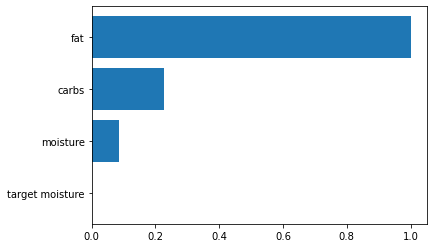

[1, 2, 4, 5]
Number of features: 4
Features: Index(['target moisture', 'moisture', 'carbs', 'fat'], dtype='object')
Root Mean Squared Error (RMSE): 14.695
Root Mean Squared Train Error (RMSE): 6.516
Adjusted r2_score: 0.532
r2_score: 0.567
Mean Absolute Percentage Error (MAPE): 27.5%
Mean Absolute Percentage Train Error (MAPE): 0.1%


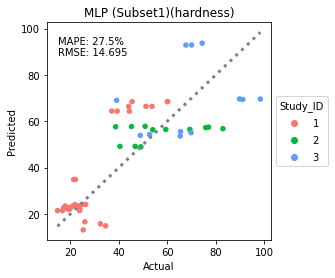

....................................................................................................
Feature: 0, Score: 0.00000
Feature: 1, Score: 0.08628
Feature: 2, Score: 0.22628
Feature: 3, Score: 1.00000


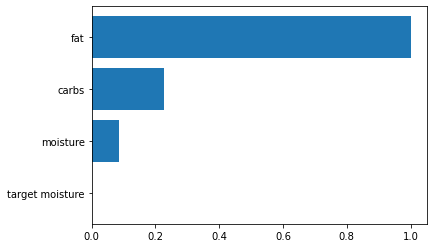

In [9]:
from sklearn.neural_network import MLPRegressor
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePGroupsOut
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression#mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
    
from matplotlib.colors import ListedColormap
    
#data =pd.read_csv('./../Feature_Subsets/30_12_12.csv',header=0)
#features_all=data.iloc[:,1:8]
data =pd.read_csv('./../Feature_Subsets/additional_30_12_12.csv',header=0)
features_all=data.iloc[:,2:9]
columns = list(features_all.columns)

Subsets_Chew =[['target moisture','moisture','carbs','fat']]

for sub_i in range(len(Subsets_Chew)):

    response = 'hardness'
    if response=='crosswise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,6:7])
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,6:7].head())

    elif response=='lengthwise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,7:8])    
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,7:8].head())    

    elif response=='chewiness':
        #y = np.array(data.iloc[:,9:10])
        y = np.array(data.loc[:,'Chewiness'])

        print(features_all.head())
        print(data.iloc[:,10:11].head())
    elif response=='hardness':
        #y = np.array(data.iloc[:,8:9])
        y = np.array(data.loc[:,'Hardness'])
        print(features_all.head())
        print(data.iloc[:,9:10].head())        

    alphas = [0.0001,0.001,0.01,0.1,0,1,10]
    num_nodes=[1,2,3,4,5]
    act_function = [ 'relu','identity', 'logistic', 'tanh'] #relu
    solver=['sgd'] #adam
    param_grid = {
    'alpha': [0.0001,0.001,0.01,0.1,0,1,10],
    'hidden_layer_sizes':[(1,),(2,),(3,),(4,),(5,)],
     'activation': ['relu','identity', 'logistic', 'tanh']   #relu
    }
    final_importance=list()

    feat=[columns.index(i) for i in Subsets_Chew[sub_i]]
    X = np.array(features_all.iloc[:,feat])


    y_true, predictions, residuals = list(), list(), list()
    loo = LeavePGroupsOut(n_groups=1)
    #groups = data.iloc[:,10:11].values.ravel()
    groups = list(data.Group_ID)
    study_id = data.loc[:,'Study_ID']

    print(groups)
    k_fold=loo.get_n_splits(X,groups=groups)
    print(k_fold)
    grid = dict()
    est = MLPRegressor(max_iter=50000, random_state=0, solver = solver[0])

    g_mse, g_mae, g_rmse, g_r2, g_r2adj,g_mape = list(),list(),list(),list(),list(),list()
    count=0
    predictions_, y_trues_,predictions_train, y_trues_train = list(), list(), list(), list()
    labels, best_params= list(), list()
    importances=[]
    for train_index, test_index in loo.split(X,groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        count += 1
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        labels.extend(study_id[test_index])

       # scaler = StandardScaler()
       # y_train = scaler.fit_transform(y_train)
       # y_test = scaler.transform(y_test)
        reg = GridSearchCV(estimator=est, return_train_score=True, param_grid=param_grid, scoring='neg_mean_squared_error' ,cv=loo.split(X_train,y_train,groups=np.array(groups)[train_index]),verbose=1)
        reg.fit(X_train, y_train.ravel())

        print("Mean_val_score  ", reg.cv_results_['mean_test_score'])
        print("Mean_train_score  ", reg.cv_results_['mean_train_score'])
        print("Ratio test/train  ", reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])

        print("Best parameters  ", reg.best_params_)
        best_params.append(reg.best_params_)

        print("Best parameters test score ",np.sqrt(np.abs(reg.cv_results_['mean_test_score'][reg.best_index_])))
        print("Best parameters train score ",np.sqrt(np.abs(reg.cv_results_['mean_train_score'][reg.best_index_])))
        print("Best parameters ratio test/train ",(reg.cv_results_['mean_test_score'] / reg.cv_results_['mean_train_score'])[reg.best_index_])
       # reg = RandomForestRegressor(random_state=0).fit(X_train, y_train.ravel())
        prediction = reg.predict(X_test)
        predictions_.extend(prediction)
        y_trues_.extend(y_test.ravel())
        #plt.barh(features_all.iloc[:,feat].columns, reg.feature_importances_)
        #plt.show()
       # residual =  y_test.ravel()-prediction
       # residuals_.append(residual)          
        prediction_tr = reg.predict(X_train)

        predictions_train.extend(prediction_tr)
        y_trues_train.extend(y_train.ravel())
        results = permutation_importance(reg, X_train, y_train.ravel(), scoring='neg_mean_squared_error')
        # get importance
        importance = results.importances_mean
        x=np.abs(importance)

        importance = (x-min(x))/(max(x)-min(x))
        # summarize feature importance
        importances.append(importance)


        pred = predictions_
        true = y_trues_

    importance = np.array(importances).mean(0)
    x=np.abs(importance)

    importance = (x-min(x))/(max(x)-min(x))
    if not np.isnan(importance[0]):
        final_importance.append(importance)
  #  for i,v in enumerate(importance):
  #      print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()
    g_mse.append(mean_squared_error(true, pred))
    g_mae.append(mean_absolute_error(true, pred))
    g_rmse.append(mean_squared_error(true, pred, squared=False))
    g_mape.append(mean_absolute_percentage_error(true, pred))
    g_r2.append(r2_score(true, pred))
    g_r2adj.append(1 - (1-r2_score(true, pred))*(len(true)-1)/(len(true)-len(feat)-1))
    error =np.array(g_mse).mean()
    error2 =np.array(g_mae).mean()
    error3 =np.array(g_rmse).mean()
    error4 =  np.mean(np.abs((np.array(true) - np.array(pred))/true))*100
    r2_score_val =np.array(g_r2).mean()
    r2_adj =np.array(g_r2adj).mean()

    print(feat)
    #Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    #A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
    print('Number of features:',  len(feat))
    print('Features:',  features_all.columns[feat])
    #  print('Mean Squared Error (MSE): %.3f' % error) 
    #  print('Mean Absolute Error (MAE): %.3f' % error2) 
    print('Root Mean Squared Error (RMSE): %.3f' % error3) 
    print('Root Mean Squared Train Error (RMSE): %.3f' % mean_squared_error(y_trues_train, predictions_train, squared=False)) 

    print('Adjusted r2_score: %.3f' %r2_adj)
    print('r2_score: %.3f' % r2_score_val)
    print(f'Mean Absolute Percentage Error (MAPE): {error4:.1f}%')
    print(f'Mean Absolute Percentage Train Error (MAPE): {mean_absolute_percentage_error(y_trues_train, predictions_train):.1f}%')



    error3 = mean_squared_error(true, pred, squared=False)
    r2_score_val = r2_score(true, pred)
    adj_R2=(1 - (1-r2_score_val)*(len(true)-1)/(len(true)-((7))-1))    


    fig, ax = plt.subplots(figsize=(4,4))
    plt.text(x=0.05,y=0.85,s='RMSE: %.3f' % error3, transform=ax.transAxes)
    plt.text(x=0.05,y=0.90,s=f'MAPE: {error4:.1f}%', transform=ax.transAxes)
    #plt.text(x=0.05,y=0.95,s='Adjusted R2: %.3f' % adj_R2, transform=ax.transAxes)
    #plt.text(x=0.05,y=0.90,s='R2: %.3f' % r2_score_val, transform=ax.transAxes)


    plt.title('MLP (Subset'+str(sub_i+1)+')('+response+')')
    #ax.scatter(true, pred,labels)
    colors = ListedColormap(['#F8766D','#00BA38','#619CFF'])

    scatter=plt.scatter(true, pred,c=labels, cmap=colors,s=20)

    true=np.array(true)

    ax.plot([true.min(), true.max()], [true.min(), true.max()], linestyle = 'dotted', lw=3, color='gray')
    ax.legend(*scatter.legend_elements(),title="Study_ID", loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    plt.show()
    print(100*'.')
    final_importance = np.array(final_importance).mean(0)
    x=np.abs(final_importance)

    importance = (x-min(x))/(max(x)-min(x))
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()

In [10]:
np.savetxt(fname='best_params_'+response+'.txt' , X=best_params, fmt='%s')


## with ash

   protein  target moisture  moisture     ash   carbs    fat  fiber
0  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
1  62.6988            56.85    5.3937  4.2445  20.491  6.662   0.51
2  62.6988            57.16    5.3937  4.2445  20.491  6.662   0.51
3  63.1788            57.51    5.9137  3.9545  19.861  6.582   0.51
4  63.1788            57.24    5.9137  3.9545  19.861  6.582   0.51
   Hardness
0   46.7090
1   40.4365
2   49.0595
3   38.6525
4   50.8115
[5, 5, 5, 6, 6, 6, 7, 7, 7, 8, 8, 8, 9, 9, 9, 10, 10, 10, 11, 11, 11, 12, 12, 12, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4]
12
Fitting 11 folds for each of 140 candidates, totalling 1540 fits
Best parameters   {'activation': 'relu', 'alpha': 0, 'hidden_layer_sizes': (1,)}
Fitting 11 folds for each of 140 candidates, totalling 1540 fits
Best parameters   {'activation': 'tanh', 'alpha': 1, 'hidden_layer_sizes': (4,)}
Fitting 11 folds for each of 140 candidates, totallin

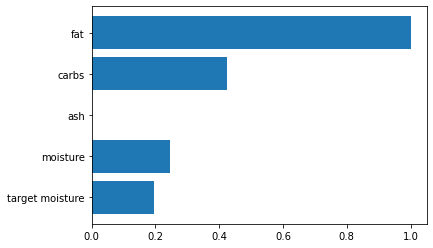

[1, 2, 3, 4, 5]
Number of features: 5
Features: Index(['target moisture', 'moisture', 'ash', 'carbs', 'fat'], dtype='object')
Root Mean Squared Error (RMSE): 25.949
Adjusted r2_score: -0.491
r2_score: -0.351
Mean absolute percentage error (MAPE): 74.6%


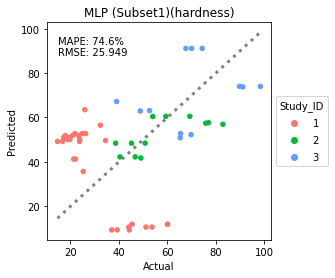

....................................................................................................
Feature: 0, Score: 0.19598
Feature: 1, Score: 0.24448
Feature: 2, Score: 0.00000
Feature: 3, Score: 0.42508
Feature: 4, Score: 1.00000


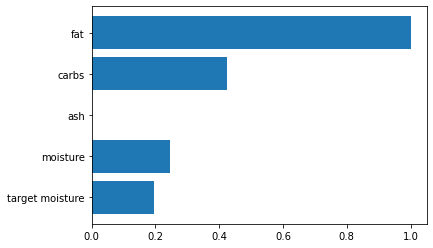

In [4]:
from sklearn.neural_network import MLPRegressor
import shap
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import LeavePGroupsOut
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression#mutual_info_regression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import itertools
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.pyplot as plt
# permutation feature importance with knn for regression
from sklearn.datasets import make_regression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from matplotlib import pyplot
    
from matplotlib.colors import ListedColormap
    
#data =pd.read_csv('./../Feature_Subsets/30_12_12.csv',header=0)
#features_all=data.iloc[:,1:8]
data =pd.read_csv('./../../Feature_Subsets/additional_30_12_12.csv',header=0)
features_all=data.iloc[:,2:9]
columns = list(features_all.columns)

Subsets_Chew =[['target moisture','moisture','ash','carbs','fat']]

for sub_i in range(len(Subsets_Chew)):

    response = 'hardness'
    if response=='crosswise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,6:7])
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,6:7].head())

    elif response=='lengthwise':
        X = np.array(features_all)
       # y = np.array(features_all.iloc[:,7:8])    
       # print(features_all.iloc[:, np.r_[0:1, np.r_[8:13,14:15]]].head())
       # print(features_all.iloc[:,7:8].head())    

    elif response=='chewiness':
        #y = np.array(data.iloc[:,9:10])
        y = np.array(data.loc[:,'Chewiness'])

        print(features_all.head())
        print(data.iloc[:,10:11].head())
    elif response=='hardness':
        #y = np.array(data.iloc[:,8:9])
        y = np.array(data.loc[:,'Hardness'])
        print(features_all.head())
        print(data.iloc[:,9:10].head())        

    alphas = [0.0001,0.001,0.01,0.1,0,1,10]
    num_nodes=[1,2,3,4,5]
    act_function = [ 'relu','identity', 'logistic', 'tanh'] #relu
    solver=['sgd'] #adam
    param_grid = {
    'alpha': [0.0001,0.001,0.01,0.1,0,1,10],
    'hidden_layer_sizes':[(1,),(2,),(3,),(4,),(5,)],
     'activation': ['relu','identity', 'logistic', 'tanh']   #relu
    }
    final_importance=list()

    feat=[columns.index(i) for i in Subsets_Chew[sub_i]]
    X = np.array(features_all.iloc[:,feat])


    y_true, predictions, residuals = list(), list(), list()
    loo = LeavePGroupsOut(n_groups=1)
    #groups = data.iloc[:,10:11].values.ravel()
    groups = list(data.Group_ID)
    study_id = data.loc[:,'Study_ID']

    print(groups)
    k_fold=loo.get_n_splits(X,groups=groups)
    print(k_fold)
    grid = dict()
    est = MLPRegressor(max_iter=50000, random_state=0, solver = solver[0])

    g_mse, g_mae, g_rmse, g_r2, g_r2adj,g_mape = list(),list(),list(),list(),list(),list()
    count=0
    predictions_, y_trues_ = list(), list()
    labels= list()
    importances=[]
    for train_index, test_index in loo.split(X,groups=groups):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        count += 1
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        labels.extend(study_id[test_index])

       # scaler = StandardScaler()
       # y_train = scaler.fit_transform(y_train)
       # y_test = scaler.transform(y_test)
        reg = GridSearchCV(estimator=est, param_grid=param_grid, scoring='neg_mean_squared_error' ,cv=loo.split(X_train,y_train,groups=np.array(groups)[train_index]),verbose=1)
        reg.fit(X_train, y_train.ravel())

        print("Best parameters  ", reg.best_params_)
       # reg = RandomForestRegressor(random_state=0).fit(X_train, y_train.ravel())
        prediction = reg.predict(X_test)
        predictions_.extend(prediction)
        y_trues_.extend(y_test.ravel())
        #plt.barh(features_all.iloc[:,feat].columns, reg.feature_importances_)
        #plt.show()
       # residual =  y_test.ravel()-prediction
       # residuals_.append(residual)          

        results = permutation_importance(reg, X_train, y_train.ravel(), scoring='neg_mean_squared_error')
        # get importance
        importance = results.importances_mean
        x=np.abs(importance)

        importance = (x-min(x))/(max(x)-min(x))
        # summarize feature importance
        importances.append(importance)


        pred = predictions_
        true = y_trues_

    importance = np.array(importances).mean(0)
    x=np.abs(importance)

    importance = (x-min(x))/(max(x)-min(x))
    if not np.isnan(importance[0]):
        final_importance.append(importance)
  #  for i,v in enumerate(importance):
  #      print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()
    g_mse.append(mean_squared_error(true, pred))
    g_mae.append(mean_absolute_error(true, pred))
    g_rmse.append(mean_squared_error(true, pred, squared=False))
    g_mape.append(mean_absolute_percentage_error(true, pred))
    g_r2.append(r2_score(true, pred))
    g_r2adj.append(1 - (1-r2_score(true, pred))*(len(true)-1)/(len(true)-len(feat)-1))
    error =np.array(g_mse).mean()
    error2 =np.array(g_mae).mean()
    error3 =np.array(g_rmse).mean()
    error4 =  np.mean(np.abs((np.array(true) - np.array(pred))/true))*100
    r2_score_val =np.array(g_r2).mean()
    r2_adj =np.array(g_r2adj).mean()

    print(feat)
    #Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
    #A constant model that always predicts the expected value of y, disregarding the input features, would get a  score of 0.0.
    print('Number of features:',  len(feat))
    print('Features:',  features_all.columns[feat])
    #  print('Mean Squared Error (MSE): %.3f' % error) 
    #  print('Mean Absolute Error (MAE): %.3f' % error2) 
    print('Root Mean Squared Error (RMSE): %.3f' % error3) 
    print('Adjusted r2_score: %.3f' %r2_adj)
    print('r2_score: %.3f' % r2_score_val)
    print(f'Mean absolute percentage error (MAPE): {error4:.1f}%')


    error3 = mean_squared_error(true, pred, squared=False)
    r2_score_val = r2_score(true, pred)
    adj_R2=(1 - (1-r2_score_val)*(len(true)-1)/(len(true)-((7))-1))    


    fig, ax = plt.subplots(figsize=(4,4))
    plt.text(x=0.05,y=0.85,s='RMSE: %.3f' % error3, transform=ax.transAxes)
    plt.text(x=0.05,y=0.90,s=f'MAPE: {error4:.1f}%', transform=ax.transAxes)
    #plt.text(x=0.05,y=0.95,s='Adjusted R2: %.3f' % adj_R2, transform=ax.transAxes)
    #plt.text(x=0.05,y=0.90,s='R2: %.3f' % r2_score_val, transform=ax.transAxes)


    plt.title('MLP (Subset'+str(sub_i+1)+')('+response+')')
    #ax.scatter(true, pred,labels)
    colors = ListedColormap(['#F8766D','#00BA38','#619CFF'])

    scatter=plt.scatter(true, pred,c=labels, cmap=colors,s=20)

    true=np.array(true)

    ax.plot([true.min(), true.max()], [true.min(), true.max()], linestyle = 'dotted', lw=3, color='gray')
    ax.legend(*scatter.legend_elements(),title="Study_ID", loc='center left', bbox_to_anchor=(1, 0.5))

    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')

    plt.show()
    print(100*'.')
    final_importance = np.array(final_importance).mean(0)
    x=np.abs(final_importance)

    importance = (x-min(x))/(max(x)-min(x))
    for i,v in enumerate(importance):
        print('Feature: %0d, Score: %.5f' % (i,v))
    # plot feature importance
    pyplot.barh(features_all.iloc[:,feat].columns, importance)
    pyplot.show()

In [10]:
reg.best_estimator_.n_outputs_

1